In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
import random

In [2]:
# Cargar los datos
df = pd.read_csv('../datos_simulados/datos_final.csv')
# Variables categóricas importantes
#columnas_categoricas = ['Clase', 'Pieza', 'Superficie_1', 'Superficie_2', 'Estado_cavidad', 'Tecnica']
columnas_categoricas = ['Clase', 'Pieza', 'Superficie_1', 'Superficie_2', 'Tecnica']
# Variables numéricas relevantes
columnas_numericas = ['Tamanio_cavidad_mm', 'Indice_contraccion_%', 'Margen_cavo_mm']

# Codificar variables categóricas
df_codificado = pd.get_dummies(df[columnas_categoricas + columnas_numericas])

# Definir X (entradas) e y (salida)
X = df_codificado
y = df['Peso_resina_inicial_mg'] - df['Peso_sobrante_mg']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Normalizar características con StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Crear el modelo secuencial
modelo_mlp = Sequential()
modelo_mlp.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
modelo_mlp.add(Dense(32, activation='relu'))
modelo_mlp.add(Dense(16, activation='relu'))
modelo_mlp.add(Dense(1))  # salida para regresión

C:\Users\mau_a\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compilar
modelo_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar
historial = modelo_mlp.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4117.7964 - mae: 53.3206 - val_loss: 265.5789 - val_mae: 13.7562
Epoch 2/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 257.7087 - mae: 13.4587 - val_loss: 260.9696 - val_mae: 13.6735
Epoch 3/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 258.4522 - mae: 13.5342 - val_loss: 260.5343 - val_mae: 13.6959
Epoch 4/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 255.7116 - mae: 13.4398 - val_loss: 260.3815 - val_mae: 13.6451
Epoch 5/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 251.0497 - mae: 13.3211 - val_loss: 261.2296 - val_mae: 13.6939
Epoch 6/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 254.5803 - mae: 13.4095 - val_loss: 259.1245 - val_mae: 13.6504
Epoch 7/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 257.7098 - mae: 13.5083 - val_loss: 261.4565 - val_mae: 13.6910
Epoch 8/100
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 251.0467 - mae: 13.2810 - val_loss: 264.0968 - val_mae: 13.7011

In [6]:
# Evaluar el modelo en el conjunto de prueba
test_mse, test_mae = modelo_mlp.evaluate(X_test_scaled, y_test, verbose=0)
print(f"MAE en prueba: {test_mae:.2f}")
print(f"MSE en prueba: {test_mse:.2f}")

MAE en prueba: 13.80
MSE en prueba: 262.75


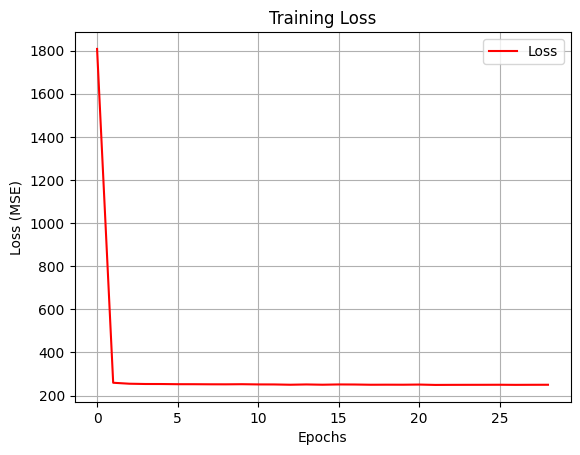

In [7]:
# Recuperar la pérdida por época durante el entrenamiento
train_loss_history = historial.history['loss']
epochs = range(len(train_loss_history))

# Gráfica general de pérdida
plt.plot(epochs, train_loss_history, 'r')
plt.title('Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend(["Loss"])
plt.grid(True)
plt.show()

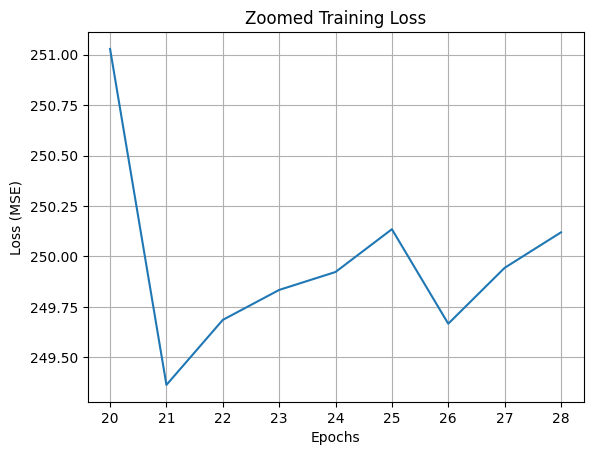

In [8]:
# Zoom a partir de la época 20
zoomed_loss = train_loss_history[20:]
zoomed_epochs = range(20, len(train_loss_history))

plt.plot(zoomed_epochs, zoomed_loss)
plt.title("Zoomed Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()

In [9]:
# Hacer predicciones sobre el conjunto de prueba
y_pred = modelo_mlp.predict(X_test_scaled)

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular R²
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 16.21
R²: 0.35


In [10]:
# Calcular la media del valor real de la resina inicial
media_real = df["Peso_resina_inicial_mg"].mean()

# RMSE obtenido tras evaluación del modelo
rmse = rmse  # Sustituye por el valor real si cambia

# Calcular el error relativo porcentual
error_relativo_pct = (rmse / media_real) * 100
precision_aproximada = 100 - error_relativo_pct

# Mostrar resultados
print(f"Media real de peso de resina inicial: {media_real:.2f} mg")
print(f"RMSE: {rmse:.2f} mg")
print(f"Error relativo aproximado: {error_relativo_pct:.2f} %")
print(f"Precisión aproximada del modelo: {precision_aproximada:.2f} %")

Media real de peso de resina inicial: 96.43 mg
RMSE: 16.21 mg
Error relativo aproximado: 16.81 %
Precisión aproximada del modelo: 83.19 %


In [11]:
# Diccionario de índice de contracción
indice_contraccion = {
    "Compuesta": 2.0,
    "Fluida": 3.5,
    "Con fibra de vidrio": 1.0,
    "Bulk": 1.5
}

# Configuraciones posibles
tecnicas = ["Bulk", "Estratificacion"]
tipos_resina = list(indice_contraccion.keys())
ajustes_margen = ["Sobreobturado", "Subobturado", "Equiobturado"]
estados_cavidad = ["con_tejido", "limpia"]

# Leer combinaciones base
df_base = pd.read_excel("../datos_simulados/Combinaciones.xlsx")

# Lista para una combinación por fila
combinaciones_X = []

for _, fila in df_base.iterrows():
    tecnica = random.choice(tecnicas)
    tipo_resina = random.choice(tipos_resina)
    indice = indice_contraccion[tipo_resina]

    tam = round(random.uniform(fila['Tam_min'], fila['Tam_max']), 2)

    ajuste = random.choice(ajustes_margen)
    if ajuste == "Equiobturado":
        margen = round(random.uniform(tam - 0.2, tam + 0.2), 2)
    elif ajuste == "Sobreobturado":
        margen = round(random.uniform(tam + 0.01, tam + 1.0), 2)
    else:
        margen = round(random.uniform(max(0.1, tam - 1.0), tam - 0.01), 2)

    combinaciones_X.append({
        "Clase": fila["Clase"],
        "Pieza": fila["Pieza"],
        "Superficie_1": fila["Superficie_1"],
        "Superficie_2": fila["Superficie_2"],
        "Estado_cavidad": random.choice(estados_cavidad),
        "Tecnica": tecnica,
        "Tamanio_cavidad_mm": tam,
        "Indice_contraccion_%": indice,
        "Margen_cavo_mm": margen
    })

# Crear DataFrame con combinaciones generadas
df_combos = pd.DataFrame(combinaciones_X)

# Codificar y alinear columnas como en el entrenamiento
df_combos_codificado = pd.get_dummies(df_combos)
df_combos_codificado = df_combos_codificado.reindex(columns=X_train.columns, fill_value=0)

# Aplicar el mismo escalado
df_combos_scaled = scaler.transform(df_combos_codificado)

# Predecir la resina inicial
resina_recomendada = modelo_mlp.predict(df_combos_scaled)

# Mostrar resultados
for i, valor in enumerate(resina_recomendada.flatten(), start=1):
    datos = df_combos.loc[i - 1]
    print(f"Combinación {i} → {valor:.2f} mg | Cavidad: {datos['Tamanio_cavidad_mm']} mm | Clase: {datos['Clase']}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Combinación 1 → 76.67 mg | Cavidad: 3.45 mm | Clase: I
Combinación 2 → 82.40 mg | Cavidad: 2.81 mm | Clase: I
Combinación 3 → 79.56 mg | Cavidad: 3.63 mm | Clase: I
Combinación 4 → 78.49 mg | Cavidad: 1.86 mm | Clase: I
Combinación 5 → 81.34 mg | Cavidad: 2.27 mm | Clase: I
Combinación 6 → 78.50 mg | Cavidad: 2.83 mm | Clase: I
Combinación 7 → 79.06 mg | Cavidad: 4.92 mm | Clase: I
Combinación 8 → 81.10 mg | Cavidad: 2.42 mm | Clase: I
Combinación 9 → 80.22 mg | Cavidad: 2.56 mm | Clase: I
Combinación 10 → 77.08 mg | Cavidad: 4.54 mm | Clase: I
Combinación 11 → 81.68 mg | Cavidad: 3.18 mm | Clase: I
Combinación 12 → 78.55 mg | Cavidad: 2.41 mm | Clase: I
Combinación 13 → 77.75 mg | Cavidad: 2.23 mm | Clase: I
Combinación 14 → 81.31 mg | Cavidad: 4.61 mm | Clase: I
Combinación 15 → 78.59 mg | Cavidad: 3.3 mm | Clase: I
Combinación 16 → 81.23 mg | Cavidad: 2.46 mm | Clase: I
Combinación 17 → 78.30 mg | Cavidad: 3.18 mm | Clase: I
Combinación 18 → 81.